# CNA Homework

## Part 1

**Reddit Networks**

Using the [Reddit networks dataset](http://dynamics.cs.washington.edu/nobackup/reddit/), select the subreddit of your favorite TV show (or you can choose any other dataset, containing the network data). Answer the following questions:

In [1]:
#!pip install turicreate

In [2]:
!wget http://dynamics.cs.washington.edu/nobackup/reddit/theoffice.tar.gz

--2022-01-11 23:08:41--  http://dynamics.cs.washington.edu/nobackup/reddit/theoffice.tar.gz
Resolving dynamics.cs.washington.edu (dynamics.cs.washington.edu)... 128.208.3.120, 2607:4000:200:12::78
Connecting to dynamics.cs.washington.edu (dynamics.cs.washington.edu)|128.208.3.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3550974 (3.4M) [application/x-gzip]
Saving to: ‘theoffice.tar.gz.1’

theoffice.tar.gz.1   30%[=====>              ]   1.03M  86.6KB/s    eta 35s    ^C


In [2]:
import tarfile
fname = 'theoffice.tar.gz'
tar = tarfile.open(fname, "r:gz")
tar.extractall(path="./data/")
tar.close()

In [3]:
import os
import turicreate as tc 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

g = tc.SGraph()
graphs_dir = 'data'
sframes_paths = [graphs_dir +'/' + s for s in os.listdir(graphs_dir)]
for folder in tqdm(sframes_paths):
    if not folder.endswith(".sgraph"):
        continue
    subG = tc.load_sgraph(folder)
    g = g.add_vertices(subG.get_vertices())
    g = g.add_edges(subG.get_edges())

100%|██████████| 49/49 [08:17<00:00, 10.16s/it]


In [4]:
# converv SGraph to networkx, if needed

import networkx as nx

def sgraph2nxgraph(sgraph, is_directed=True, add_vertices_attributes=True, add_edges_attributes=True):
    if is_directed:
        nx_g = nx.DiGraph()
    else:
        nx_g = nx.Graph()
    if add_vertices_attributes:
        vertices = [(r['__id'] , r) for r in sgraph.vertices]
    else:
        vertices = list(sgraph.get_vertices()['__id'])

    if add_edges_attributes:
        edges = [(r['__src_id'], r['__dst_id'], r) for r in sgraph.edges]
    else:
        edges = [(e['__src_id'], e['__dst_id']) for e in sgraph.get_edges()]
    nx_g.add_nodes_from(vertices)
    nx_g.add_edges_from(edges)
    return nx_g

**Task 1 (_max score - 10 points_)**: Calculate and visualize the degree distribution of the vertices in the network

In [5]:
gnx = sgraph2nxgraph(g)

/Users/adahan/opt/anaconda3/envs/ds38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


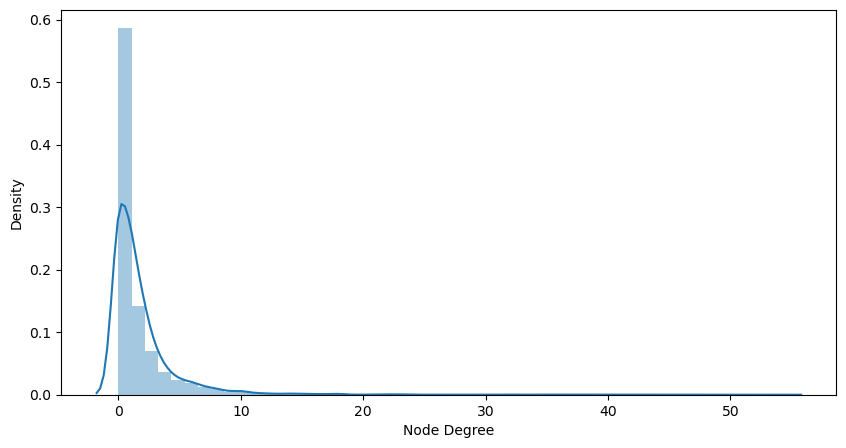

In [23]:
import numpy as np
import seaborn as sns

degrees = [gnx.degree(n) for n in gnx.nodes()]

plt.figure(figsize=(10, 5))
sns.distplot(np.array(degrees))
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.show()

**Task 2 (_max score - 15 points_)**: Create a subgraph of the top-20 users according to the PageRank algorithm. Draw the subgraph.

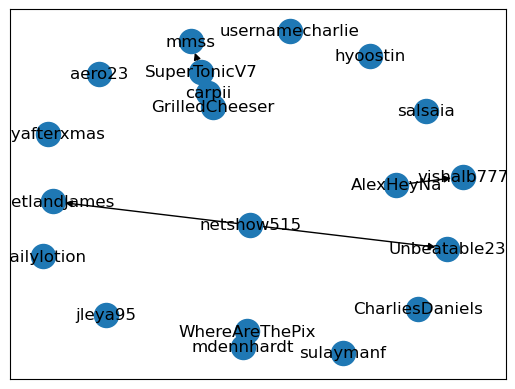

In [65]:
from networkx.algorithms.link_analysis.pagerank_alg import pagerank

pr = pagerank(gnx, max_iter=1000)
top_20_users = dict(sorted(pr.items(), key=lambda x: x[1], reverse=True)[:20]).keys()
top_20_subgraph = gnx.subgraph(top_20_users)
nx.draw_networkx(top_20_subgraph)
plt.show()

**Task 3 (_max score - 15 points_)**: Visualize the distribution of the network's strongly and weakly connected components.

* As we didn't have the chance to review this in class, you can read shortly about these terms [here](https://www.geeksforgeeks.org/check-if-a-graph-is-strongly-unilaterally-or-weakly-connected/)
* This might be helpful: [networkx.weakly_connected_components](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.weakly_connected_components.html?highlight=weakly_connected_components#networkx.algorithms.components.weakly_connected_components) 

/Users/adahan/opt/anaconda3/envs/ds38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adahan/opt/anaconda3/envs/ds38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


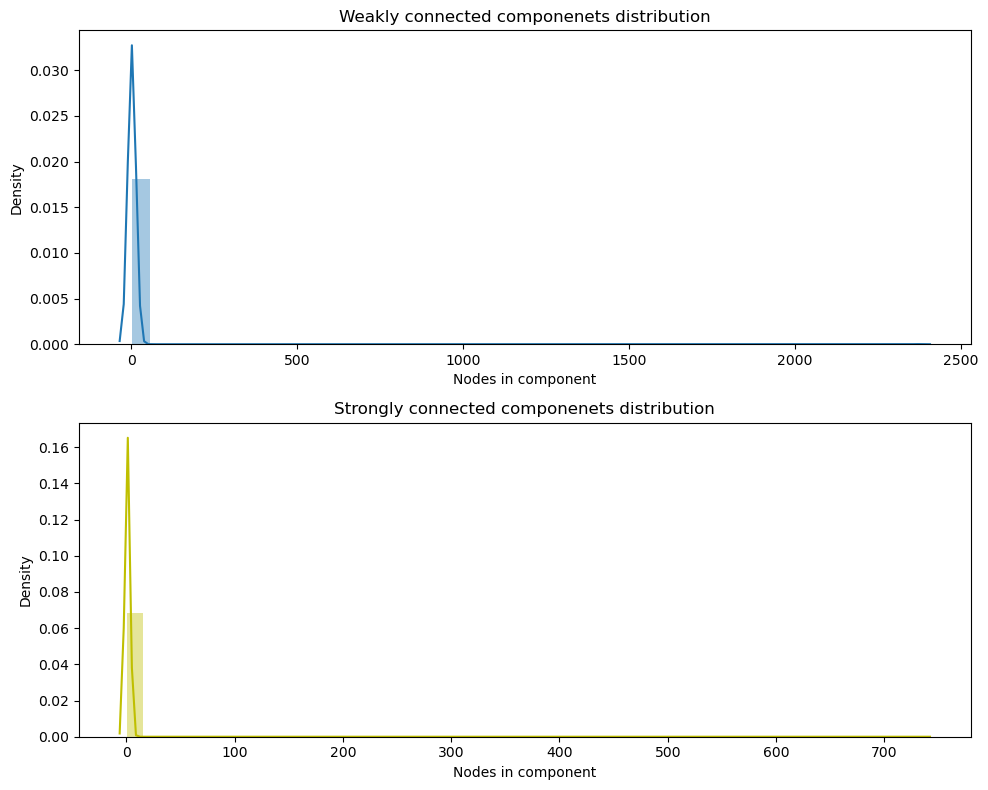

In [81]:
# Finding the number of nodes per component
weak_c = [len(i) for i in list(nx.weakly_connected_components(gnx))]
strong_c = [len(i) for i in list(nx.strongly_connected_components(gnx))]


# Plotting
plt.figure(figsize=(10, 8))

ax1 = plt.subplot(2, 1, 1)
ax = sns.distplot(np.array(weak_c))
plt.title('Weakly connected componenets distribution')
plt.xlabel('Nodes in component')
plt.ylabel('Density')


ax2 = plt.subplot(2, 1, 2)
ax = sns.distplot(np.array(strong_c), color="y")
plt.title('Strongly connected componenets distribution')
plt.xlabel('Nodes in component')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


**Task 4 (_max score - 10 points_)**: Split the network into communities, and find the __second__ most central vertex in each community (use degree_centrality).

Let's take the greedy modularity maximization community detection algorithm we learned in class, just as a reminder, we've learned in class about:
- Girvan-Newman algorithm
- Bottom up greedy modularity maximization

**Modularity greedy maximization**

In [102]:
from networkx.algorithms.centrality import degree_centrality
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

communities = greedy_modularity_communities(gnx)

second_best_gmc = {}

for community in communities:
    community_sub_graph = gnx.subgraph(community)
    centrality_values = degree_centrality(community_sub_graph)

    if len(centrality_values) == 1:
        # If the community is in size 1 just return the centrality
        second_most_central = max(centrality_values.values())
    else:
        second_most_central = sorted(centrality_values.items(), key=lambda x: x[1], reverse=True)[-2]

    second_best_gmc[community] = second_most_central

print(second_best_gmc)

{frozenset({'lakerfan91', 'xadz', 'Koufos', 'gamgeestar', 'AngryWillie', 'hapam0de', 'ThePensiveCitizen', 'toohighm', 'bizzo98', 'bumhaskins', 'Caputalis', 'MunozMandoMan', 'Cern_Stormrunner', 'minimus_composite', 'mo_money_moproblems', 'blarb', '0x537', 'flyblackbox', 'TheExits', 'RDiaz', 'GrilledCheeser', 'no_known_filter', 'OneOfDozens', 'garriusbearius', 'philaderpia', 'TheBookSeer', 'Draven_You_Crazy', 'Hails23', 'mikekalil', 'darlingpinky', 'SugarSugarBee', 'DonaEisRequiem', 'la_Policia_Ideologia', 'apandacoon', 'SystemS5', 'puglovers', 'NattyBro410', 'ericf0ster', 'alchemeron', 'rhlowe', 'magmabrew', 'abadbronc', 'Jawshewah', 'anonymouswriter9', 'book_keeper', 'KrustyFrank27', 'lionsmane07', 'loveandmonsters', 'Echobelly', 'hilat', 'LibraryDrone', 'AerithFaremis', 'LEGEN_waitforit_DARY', 'Becco', 'wyldeyez', 'Ejryerson', 'Stephen_Normal', 'bizcat', 'fuckinwhitegirl', 'darkstar9454', 'pordavid', 'Stretch2194', 'semimedium', 'eagerbeaver1414', 'getjustin', 'Karthane', 'DaymanX', '

## Part 2

In [1]:
import networkx as nx
from networkx.algorithms.centrality import *
from scipy.stats import spearmanr 
from networkx.generators.geometric import random_geometric_graph 
from networkx.algorithms.community import * 

### Lets generate some networks

Every network contains four sets of nodes. $a\in \{0.1,0.01\}$ is the probability for an edge between two nodes in the same set. $b\in \{0.1,0.01\}$ is the probability for an edge between two nodes in different communities.

In [2]:
blocks = [100,100,100,100]
probs = [
        [[a,b,b,b],
         [b,a,b,b],
         [b,b,a,b],
         [b,b,b,a]]
    for a,b in [(0.01,0.01),(0.1,0.01),(0.01,0.1)]
    ]

In [3]:
nets = [nx.generators.community.stochastic_block_model(blocks,p) for p in probs*100]
print("There are {} networks in total.".format(len(nets)))

There are 300 networks in total.


### Node centrality **(_max score - 10 points_)**
Your code is here: replace [] accordingly to the comment in the row



In [4]:
centralities =  [ {
                    'degree': list(degree_centrality(G).values()), #replace [] with a sequence of node degree centralities 
                    'closeness': list(closeness_centrality(G).values()), #replace [] with a sequence of node closeness centralities  
                    'betweenness': list(betweenness_centrality(G).values()) #replace [] with a sequence of node betweenness centralities
                  } 
                for G in nets
                ]

In [5]:
#here we compute the corralations between the three centrality measures for each network
#every network is characterized by the tripplet of centrality correlations
centrality_correlations = [
    (
        spearmanr(c['degree'],c['closeness'])[0],
        spearmanr(c['degree'],c['betweenness'])[0],
        spearmanr(c['betweenness'],c['closeness'])[0],
    )
    for c in centralities
]

### Build a meta-network

where networks are nodes connected by an edge if their centrality correlations are similar 

In [6]:
radius = 0.025
G = random_geometric_graph(n=len(nets), radius=radius, dim=3, pos=dict(enumerate(centrality_correlations)))

In [7]:
print("number of nodes in G is the same as the number of networks in nets:{}".format(G.number_of_nodes()))
print("number of edges in G is:{}".format(G.number_of_edges()))

number of nodes in G is the same as the number of networks in nets:300
number of edges in G is:10244


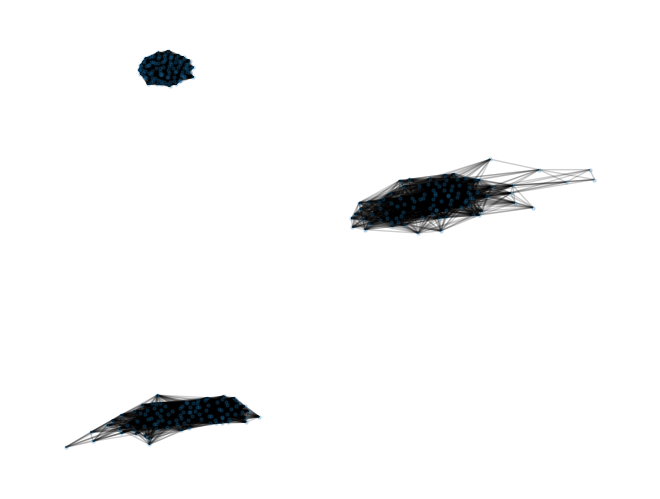

In [10]:
pos = nx.spring_layout(G)
nx.draw(G, pos=pos,node_size=5,alpha=0.2)
plt.show()

### Communities

#### What is the number of communities in nets[1]? **(_max score - 10 points_)**
- Use _greedy_modularity_communities_

In [11]:
#find the community structure of nets[1] and print the number of communities in nets[1]

coms = greedy_modularity_communities(nets[1])
print(f"Number of communities in nets[1]: {len(coms)}")
print(f"Community sized in nets[1]: {[len(com) for com in coms]}")


Number of communities in nets[1]: 4
Community sized in nets[1]: [102, 101, 100, 97]


#### How could you know it without running community detection? **(_max score - 10 points_)**

We could know it by the way we build our networks.

We use stochastic_block_model which partitions the nodes to blocks with diffrenet sizes and places edges between the nodes in the block by probability for each block. 

This actually means that each block is a community because the list of blocks contain 4 sizes, we can assume that we will get 4 communities to each net. 

#### What is the number of communities in the meta-network G? **(_max score - 10 points_)**

In [12]:
# Find the number of communities in G

coms_g = greedy_modularity_communities(G)
print(f"Number of communities in nets[1]: {len(coms_g)}")
print(f"Community sized in nets[1]: {[len(com) for com in coms_g]}")

Number of communities in nets[1]: 3
Community sized in nets[1]: [100, 100, 100]


#### Can you explain why this is the number of communities in G? **(_max score - 10 points_)**

Again, this can be explained by the way we created G.

We used random geometric graph model, which places n nodes uniformly at random in the unit cube. 

Because we used 300 nodes and they were placed uniformly on the 3D space, we expect that the nodes will be separated to 3 communities with 100 nodes per community.